# Dependencies

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter

In [ ]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [ ]:
num2class = {"0.0" : "buffalo", "1.0" : "elephant", "2.0" : "rhino", "3.0" : "zebra"}

# Bounding boxes

In [ ]:
# box : (centerX, centerY, width, height)
def convertToAbsoluteValues(size, box):
    
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

# def convertToRelativeValues(size, box):
#     dw = 1. / (size[0])
#     dh = 1. / (size[1])
#     cx = (box[1] + box[0]) / 2.0
#     cy = (box[3] + box[2]) / 2.0
#     w = box[1] - box[0]
#     h = box[3] - box[2]
#     x = cx * dw
#     y = cy * dh
#     w = w * dw
#     h = h * dh
#     # x,y => (bounding_box_center)/width_of_the_image
#     # w => bounding_box_width / width_of_the_image
#     # h => bounding_box_height / height_of_the_image
#     return (x, y, w, h)

In [ ]:
imgfilepath = os.path.join("image", "022" + ".jpg")
print(imgfilepath)
img = cv.imread(imgfilepath)
plt_imshow("", img)
h, w, _ = img.shape
print(h,w)
label, conf, rx1, ry1, rx2, ry2 = (3, 1, 0.572656, 0.523958, 0.698438, 0.589583)
cood = convertToAbsoluteValues((w,h), (rx1, ry1, rx2, ry2 ))
print(cood)
# orig = convertToRelativeValues((w,h), (0.223437,0.2291665,0.921875,0.81875))
# print(orig)

In [44]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [49]:
labelPath = "label"
imagePath = "image"
detections, groundtruths, classes = [], [], []
for boxtype in os.listdir(labelPath):
    print(boxtype)
    boxtypeDir = os.path.join(labelPath,boxtype)
    print(boxtypeDir)

    for labelfile in os.listdir(boxtypeDir):
        print(labelfile)
        print(os.path.splitext(labelfile))
        filename = os.path.splitext(labelfile)[0]
        print(filename)
        print(os.path.join(boxtypeDir, labelfile))
        with open(os.path.join(boxtypeDir, labelfile)) as f:
            labelinfos = f.readlines()
        print(labelinfos)

        imgfilepath = os.path.join(imagePath, filename + ".jpg")
        img = cv.imread(imgfilepath)
        h, w, _ = img.shape
        print(w,h)
        for labelinfo in labelinfos:
#             print(labelinfo, type(labelinfo))
#             print(labelinfo.strip().split())
#             label, conf, rx1, ry1, rx2, ry2  = map(float, labelinfo.strip().split())
#             print(label, conf, rx1, ry1, rx2, ry2 )
            label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
            x1, y1, x2, y2 = convertToAbsoluteValues((w, h), (rx1, ry1, rx2, ry2))
            boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
            print(boxinfo)
                
            if label not in classes:
                classes.append(label)
            print(classes)
                
            if boxtype == "detection":
                detections.append(boxinfo)
            else:
                groundtruths.append(boxinfo)
            print(detections)
            print(groundtruths)
        
    

detection
label/detection
022.txt
('022', '.txt')
022
label/detection/022.txt
['3 0.7 0.657031 0.653125 0.648438 0.552083\n']
640 480
['022', 3.0, 0.7, (213, 181, 628, 446)]
[3.0]
[['022', 3.0, 0.7, (213, 181, 628, 446)]]
[]
199.txt
('199', '.txt')
199
label/detection/199.txt
['1 0.48 0.239844 0.532009 0.348438 0.640177\n']
640 453
['199', 1.0, 0.48, (42, 96, 265, 386)]
[3.0, 1.0]
[['022', 3.0, 0.7, (213, 181, 628, 446)], ['199', 1.0, 0.48, (42, 96, 265, 386)]]
[]
338.txt
('338', '.txt')
338
label/detection/338.txt
['3 0.47 0.517250 0.780167 0.272500 0.384707\n', '3 0.33 0.658500 0.710872 0.271000 0.499403\n', '3 0.89 0.927750 0.210872 0.144500 0.419355\n', '1 0.72 0.381500 0.321386 0.419000 0.528076\n']
2000 837
['338', 3.0, 0.47, (762, 492, 1307, 814)]
[3.0, 1.0]
[['022', 3.0, 0.7, (213, 181, 628, 446)], ['199', 1.0, 0.48, (42, 96, 265, 386)], ['338', 3.0, 0.47, (762, 492, 1307, 814)]]
[]
['338', 3.0, 0.33, (1046, 386, 1588, 804)]
[3.0, 1.0]
[['022', 3.0, 0.7, (213, 181, 628, 446)], 

2000 1333
['317', 3.0, 0.34, (143, 775, 543, 1067)]
[3.0, 1.0, 0.0, 2.0]
[['022', 3.0, 0.7, (213, 181, 628, 446)], ['199', 1.0, 0.48, (42, 96, 265, 386)], ['338', 3.0, 0.47, (762, 492, 1307, 814)], ['338', 3.0, 0.33, (1046, 386, 1588, 804)], ['338', 3.0, 0.89, (1711, 1, 1999, 352)], ['338', 1.0, 0.72, (344, 48, 1182, 490)], ['297', 0.0, 0.33, (138, 173, 335, 330)], ['297', 0.0, 0.77, (499, 286, 791, 455)], ['297', 3.0, 0.12, (8, 250, 110, 416)], ['297', 3.0, 0.45, (98, 365, 232, 487)], ['297', 3.0, 0.93, (242, 291, 329, 421)], ['290', 1.0, 0.31, (30, 1, 586, 272)], ['290', 3.0, 0.5, (257, 177, 460, 366)], ['290', 3.0, 0.68, (466, 157, 594, 282)], ['363', 0.0, 0.92, (280, 69, 696, 435)], ['299', 1.0, 0.48, (407, 256, 689, 419)], ['299', 3.0, 0.71, (154, 77, 502, 334)], ['299', 2.0, 0.82, (93, 241, 212, 425)], ['099', 2.0, 0.88, (181, 355, 612, 582)], ['099', 2.0, 0.91, (373, 39, 770, 407)], ['317', 3.0, 0.34, (143, 775, 543, 1067)]]
[]
['317', 3.0, 0.56, (584, 696, 1025, 1051)]
[3.0, 1.

In [50]:
def boundingBoxes(labelPath, imagePath):
    
    detections, groundtruths, classes = [], [], []
    
    for boxtype in os.listdir(labelPath):

        boxtypeDir = os.path.join(labelPath,boxtype)

        for labelfile in os.listdir(boxtypeDir):
            filename = os.path.splitext(labelfile)[0]
            with open(os.path.join(boxtypeDir, labelfile)) as f:
                labelinfos = f.readlines()

            imgfilepath = os.path.join(imagePath, filename + ".jpg")
            img = cv.imread(imgfilepath)
            h, w, _ = img.shape

            for labelinfo in labelinfos:
                label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
                x1, y1, x2, y2 = convertToAbsoluteValues((w, h), (rx1, ry1, rx2, ry2))
                boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
                
                if label not in classes:
                    classes.append(label)
                
                if boxtype == "detection":
                    detections.append(boxinfo)
                else:
                    groundtruths.append(boxinfo)
                    
    classes = sorted(classes)
                
    return detections, groundtruths, classes

detections, groundtruths, classes = boundingBoxes("label", "image")
print(detections)
print(groundtruths)
print(classes)

[['022', 3.0, 0.7, (213, 181, 628, 446)], ['199', 1.0, 0.48, (42, 96, 265, 386)], ['338', 3.0, 0.47, (762, 492, 1307, 814)], ['338', 3.0, 0.33, (1046, 386, 1588, 804)], ['338', 3.0, 0.89, (1711, 1, 1999, 352)], ['338', 1.0, 0.72, (344, 48, 1182, 490)], ['297', 0.0, 0.33, (138, 173, 335, 330)], ['297', 0.0, 0.77, (499, 286, 791, 455)], ['297', 3.0, 0.12, (8, 250, 110, 416)], ['297', 3.0, 0.45, (98, 365, 232, 487)], ['297', 3.0, 0.93, (242, 291, 329, 421)], ['290', 1.0, 0.31, (30, 1, 586, 272)], ['290', 3.0, 0.5, (257, 177, 460, 366)], ['290', 3.0, 0.68, (466, 157, 594, 282)], ['363', 0.0, 0.92, (280, 69, 696, 435)], ['299', 1.0, 0.48, (407, 256, 689, 419)], ['299', 3.0, 0.71, (154, 77, 502, 334)], ['299', 2.0, 0.82, (93, 241, 212, 425)], ['099', 2.0, 0.88, (181, 355, 612, 582)], ['099', 2.0, 0.91, (373, 39, 770, 407)], ['317', 3.0, 0.34, (143, 775, 543, 1067)], ['317', 3.0, 0.56, (584, 696, 1025, 1051)], ['317', 3.0, 0.62, (1075, 677, 1439, 1036)], ['317', 3.0, 0.78, (1523, 589, 1894, 8

# Plot Bounding boxes

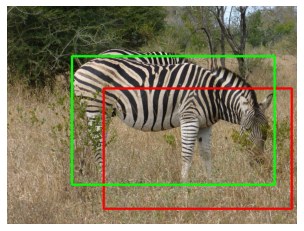

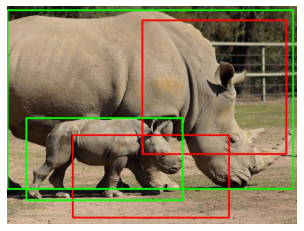

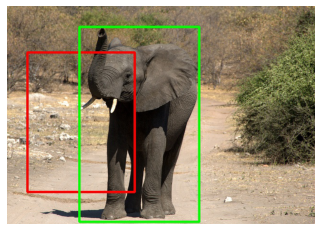

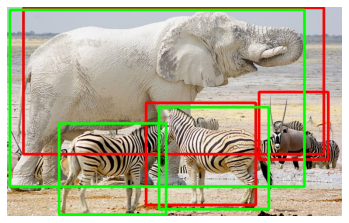

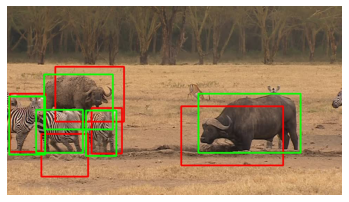

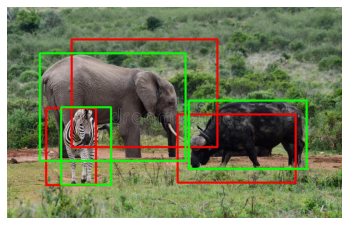

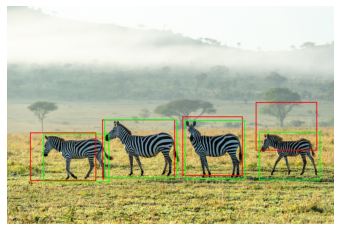

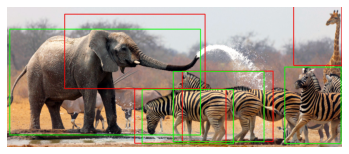

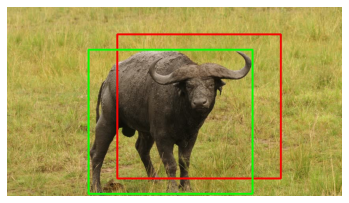

In [54]:
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, labelfile + ".jpg")
        img = cv.imread(imgfilePath)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
                
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
                
            cv.rectangle(img, (x1, y1), (x2, y2), rectcolor, 4)
        cv.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
        plt.axis("off")
        plt.imshow(img)
        plt.show()
        
# boxPlot(detections, "image", savePath="boxed_images/detection")
# boxPlot(groundtruths, "image", savePath="boxed_images/groundtruth")
boxPlot(detections + groundtruths, "image", savePath="boxed_images/both")

# IoU(Intersection over Union)

In [55]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

# boxA = (Ax1,Ay1,Ax2,Ay2)
# boxB = (Bx1,By1,Bx2,By2)
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result

In [56]:
boxA = detections[-1][-1]
boxB = groundtruths[-1][-1]

print(f"boxA coordinates : {(boxA)}")
print(f"boxA area : {getArea(boxA)}")
print(f"boxB coordinates : {(boxB)}")
print(f"boxB area : {getArea(boxB)}")

print(f"Union area of boxA and boxB : {getUnionAreas(boxA, boxB)}")

print(f"Does boxes Intersect? : {boxesIntersect(boxA, boxB)}")

print(f"Intersection area of boxA and boxB : {getIntersectionArea(boxA, boxB)}")

print(f"IoU of boxA and boxB : {iou(boxA, boxB)}")

boxA coordinates : (1523, 589, 1894, 881)
boxA area : 108996
boxB coordinates : (1544, 771, 1914, 1063)
boxB area : 108703
Union area of boxA and boxB : 178738.0
Does boxes Intersect? : True
Intersection area of boxA and boxB : 38961
IoU of boxA and boxB : 0.21797826986986538


# AP(Average Precision)

In [83]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    print("mrec=", mrec)
    mpre = [0] + [e for e in prec] + [0]
    print("mpre=", mpre)

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])
        
    print("mpre=", mpre)

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)
            
    print("ii=", ii)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
        print("ap=", ap)
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [ ]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [57]:
print(detections)
print(groundtruths)
print(classes)

[['022', 3.0, 0.7, (213, 181, 628, 446)], ['199', 1.0, 0.48, (42, 96, 265, 386)], ['338', 3.0, 0.47, (762, 492, 1307, 814)], ['338', 3.0, 0.33, (1046, 386, 1588, 804)], ['338', 3.0, 0.89, (1711, 1, 1999, 352)], ['338', 1.0, 0.72, (344, 48, 1182, 490)], ['297', 0.0, 0.33, (138, 173, 335, 330)], ['297', 0.0, 0.77, (499, 286, 791, 455)], ['297', 3.0, 0.12, (8, 250, 110, 416)], ['297', 3.0, 0.45, (98, 365, 232, 487)], ['297', 3.0, 0.93, (242, 291, 329, 421)], ['290', 1.0, 0.31, (30, 1, 586, 272)], ['290', 3.0, 0.5, (257, 177, 460, 366)], ['290', 3.0, 0.68, (466, 157, 594, 282)], ['363', 0.0, 0.92, (280, 69, 696, 435)], ['299', 1.0, 0.48, (407, 256, 689, 419)], ['299', 3.0, 0.71, (154, 77, 502, 334)], ['299', 2.0, 0.82, (93, 241, 212, 425)], ['099', 2.0, 0.88, (181, 355, 612, 582)], ['099', 2.0, 0.91, (373, 39, 770, 407)], ['317', 3.0, 0.34, (143, 775, 543, 1067)], ['317', 3.0, 0.56, (584, 696, 1025, 1051)], ['317', 3.0, 0.62, (1075, 677, 1439, 1036)], ['317', 3.0, 0.78, (1523, 589, 1894, 8

In [86]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.3, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]
        
        print(dects)
        print(gts)

        
        npos = len(gts)
        print(npos)
        

#         for conf in dects:
#             print(conf, conf[2])
            
        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)
        print(dects)
        
        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))
        
        
        det = Counter(cc[0] for cc in gts)
        print(det)
        
        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)
            
#         print(det)
        for key, val in det.items():
            print(key, val)
            
        


        for d in range(len(dects)):

            gt = [gt for gt in gts if gt[0] == dects[d][0]]
            print(gt)
            

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                print(iou1)
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j
                    
            

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1
                
        print(TP)
        print(FP)
        for key, val in det.items():
            print(key, val)
            
        
        acc_FP = np.cumsum(FP)
        print(acc_FP)
        acc_TP = np.cumsum(TP)
        print(acc_TP)
        rec = acc_TP / npos
        print(rec)
        prec = np.divide(acc_TP, (acc_FP + acc_TP))
        print(prec)

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)
        
        print([ap, mpre, mrec, ii])

        r = {
            'class' : c,
            'precision' : prec,
            'recall' : rec,
            'AP' : ap,
            'interpolated precision' : mpre,
            'interpolated recall' : mrec,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }

        result.append(r)

    return result

result = AP(detections, groundtruths, classes)
print("result=", result)

[['297', 0.0, 0.33, (138, 173, 335, 330)], ['297', 0.0, 0.77, (499, 286, 791, 455)], ['363', 0.0, 0.92, (280, 69, 696, 435)]]
[['297', 0.0, 1.0, (106, 195, 303, 352)], ['297', 0.0, 1.0, (548, 250, 841, 419)], ['363', 0.0, 1.0, (207, 108, 624, 474)], ['299', 0.0, 1.0, (434, 223, 715, 386)]]
4
[['363', 0.0, 0.92, (280, 69, 696, 435)], ['297', 0.0, 0.77, (499, 286, 791, 455)], ['297', 0.0, 0.33, (138, 173, 335, 330)]]
Counter({'297': 2, '363': 1, '299': 1})
297 [0. 0.]
363 [0.]
299 [0.]
[['363', 0.0, 1.0, (207, 108, 624, 474)]]
0.5854567090048374
[['297', 0.0, 1.0, (106, 195, 303, 352)], ['297', 0.0, 1.0, (548, 250, 841, 419)]]
0
0.4873163025009688
[['297', 0.0, 1.0, (106, 195, 303, 352)], ['297', 0.0, 1.0, (548, 250, 841, 419)]]
0.5645129025805161
0
[1. 1. 1.]
[0. 0. 0.]
297 [1. 1.]
363 [1.]
299 [0.]
[0. 0. 0.]
[1. 2. 3.]
[0.25 0.5  0.75]
[1. 1. 1.]
mrec= [0, 0.25, 0.5, 0.75, 1]
mpre= [0, 1.0, 1.0, 1.0, 0]
mpre= [1.0, 1.0, 1.0, 1.0, 0]
ii= [1, 2, 3, 4]
ap= 0.25
ap= 0.5
ap= 0.75
ap= 0.75


# mAP(mean Average Precision)

In [87]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [88]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")

buffalo  AP : 0.75
elephant AP : 0.375
 rhino   AP : 1.0
 zebra   AP : 0.4387755102040817
---------------------------
mAP : 0.6409438775510204
